# Deep Learning Course Project - Gesture Recognition
## Group Members:
- Gaurav Singh
- Kapil Shahani
- Jyoti Ahuja
### In This project we will build a #D Conv model that will be able to predict the 5 gestures correctly.

In [344]:
# Importing Libraries
import numpy as np
import os
from scipy.misc import imread, imresize
import datetime
from skimage import transform as sktf
import random as rn
import tensorflow as tf
from keras.layers import Dropout, TimeDistributed, CuDNNLSTM, Dense
from keras.layers import Flatten
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import regularizers

np.random.seed(30)
rn.seed(30)
tf.set_random_seed(30)


- In this block , you read the folder names for training and validation. You also set the batch_size here. Note that you set the batch size
  in such a way that you are able to use the GPU in full capacity. you keep increasing the batchsize untill the machine throws an error

In [345]:
os.environ.putenv("FILE_LOCKING","FALSE")

In [346]:
train_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/mnt/disks/user/project/PROJECT/Project_data/val.csv').readlines())



In [347]:
batch_size = 32 #experiment with the batch size 
HEIGHT_DIMENSION=100 
WIDTH_DIMENSION=100
INPUT_SIZE_IN_BATCH=15
INPUT_PER_FOLDER=30
y=HEIGHT_DIMENSION
z=WIDTH_DIMENSION

In [348]:
def imagResize(imag,HEIGHT_DIMENSION,WIDTH_DIMENSION):
    #CROPPING IMGAGE
    if abs(imag.shape[0]-imag.shape[1])%2==0 and imag.shape[0]-imag.shape[1]:
        dimension=abs(imag.shape[0]-imag.shape[1])
        crop=dimension//2
        if imag.shape[0]>imag.shape[1]:
            imag=imag[crop:imag.shape[0]-crop,:,:]
        elif imag.shape[0]<imag.shape[1]:
            imag=imag[:,crop:imag.shape[1]-crop,:]
    # RESIZING OF IMAGE
    imag=imresize(imag,size=(y,z),
                      interp='bilinear',mode='RGB')
        
    return imag

In [349]:
def normalize(imag):    
    return (imag[:,:,0]-imag[:,:,0].mean())/imag[:,:,0].std(), (imag[:,:,1]-imag[:,:,1].mean())/imag[:,:,1].std(), (imag[:,:,2]-imag[:,:,2].mean())/imag[:,:,2].std()


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [350]:
def generator(source_path, folder_list, batch_size):
    print("Inside generator")
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    NUM_FOLDERS=len(folder_list)
    num_batches = NUM_FOLDERS//batch_size
    remaining_batch_size=NUM_FOLDERS%batch_size
    while True:        
        t = np.random.permutation(folder_list)                
        for batch in range(num_batches): # we iteratINPUT_SIZE_IN_BATCHe,INPUT_SIZE_IN_BATCH over the number of batches
            batch_data = np.zeros((batch_size,INPUT_SIZE_IN_BATCH,y,z,3))
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            mandatory = [0,1,28,29]
            random_list_1 = rn.sample(range(2,28),INPUT_SIZE_IN_BATCH - 4)
            random_list_1.extend(mandatory)
            random_list_1.sort()
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(random_list_1): #  Iterate iver the frames/images of a folder to read them in
                    imag = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    imag = imagResize(imag,HEIGHT_DIMENSION,WIDTH_DIMENSION)
                    #NORMALIZING   
                    batch_data[folder,idx,:,:,0], batch_data[folder,idx,:,:,1], batch_data[folder,idx,:,:,2] = normalize(imag)                            
                                
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1                
                               
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        
        for batch in range(num_batches,num_batches+1): # we iterate over the number of batches
            rem_batch_data = np.zeros((remaining_batch_size*2,INPUT_SIZE_IN_BATCH,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            rem_batch_labels = np.zeros((remaining_batch_size*2,5)) # batch_labels is the one hot representation of the output
            mandatory = [0,1,28,29]
            random_list_1 = rn.sample(range(2,28),INPUT_SIZE_IN_BATCH - 4)
            random_list_1.extend(mandatory)
            random_list_1.sort()
            for folder in range(remaining_batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(random_list_1): #  Iterate iver the frames/images of a folder to read them in
                    imag = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    imag = imagResize(imag,HEIGHT_DIMENSION,WIDTH_DIMENSION)
                    #NORMALIZING   
                    rem_batch_data[folder,idx,:,:,0], rem_batch_data[folder,idx,:,:,1], rem_batch_data[folder,idx,:,:,2] = normalize(imag)
                                
                rem_batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
        yield rem_batch_data, rem_batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
        

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [351]:
curr_dt_time = datetime.datetime.now()
train_path = '/mnt/disks/user/project/PROJECT/Project_data/train'
val_path = '/mnt/disks/user/project/PROJECT/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 10 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 10


# Model
 - Here you make the model using different functionalities that Keras provides. Remember to use Conv3D and MaxPooling3D and not Conv2D and Maxpooling2D for a 3D convolution model. You would want to use TimeDistributed while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [352]:
base_model = VGG16(include_top=False, weights='imagenet',input_shape=(z, y,3))
x = base_model.output
x = Flatten()(x)

for layer in base_model.layers:
    layer.trainable = False

model = Model(inputs=base_model.input, outputs=x)

final_model_model = Sequential()
final_model_model.add(TimeDistributed(model, input_shape=(batch_input,z,y,3)))
final_model_model.add(CuDNNLSTM(64,return_sequences=False))
final_model_model.add(Dropout(0.5))
final_model_model.add(Dense(5, activation='softmax'))


- Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [353]:
optimiser = Adam(lr=0.001)#write your optimizer
final_model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (final_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_13 (TimeDis (None, 15, 4608)          14714688  
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 64)                1196544   
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 15,911,557
Trainable params: 1,196,869
Non-trainable params: 14,714,688
_________________________________________________________________
None


- Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [354]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [355]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2,verbose=1,mode='auto',min_delta=0.0001,cooldown=0,min_lr=0.000001)# write the REducelronplateau code here
ES = EarlyStopping(monitor='val_categorical_accuracy', min_delta=0, patience=10, verbose=1, mode='auto', baseline=None)
callbacks_list = [checkpoint, LR,ES]

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

In [356]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [357]:
final_model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=50, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Inside generator
Source path =  /mnt/disks/user/project/PROJECT/Project_data/val ; batch size = 32
Inside generator
Source path =  Epoch 1/50
/mnt/disks/user/project/PROJECT/Project_data/train ; batch size = 32


/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


 2/21 [=>............................] - ETA: 1:15 - loss: 0.1161 - categorical_accuracy: 0.9688

/mnt/disks/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


21/21 [==============================] - 79s 4s/step - loss: 0.3055 - categorical_accuracy: 0.9038 - val_loss: 0.5539 - val_categorical_accuracy: 0.7885

Epoch 00001: saving model to model_init_2019-07-0117_55_35.583576/model-00001-0.30706-0.90233-0.55392-0.78846.h5
Epoch 2/50
21/21 [==============================] - 41s 2s/step - loss: 0.2374 - categorical_accuracy: 0.9395 - val_loss: 0.6291 - val_categorical_accuracy: 0.7692

Epoch 00002: saving model to model_init_2019-07-0117_55_35.583576/model-00002-0.23445-0.94023-0.62912-0.76923.h5
Epoch 3/50
21/21 [==============================] - 51s 2s/step - loss: 0.2554 - categorical_accuracy: 0.9115 - val_loss: 0.6409 - val_categorical_accuracy: 0.7500

Epoch 00003: saving model to model_init_2019-07-0117_55_35.583576/model-00003-0.25293-0.91108-0.64095-0.75000.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/50
21/21 [==============================] - 48s 2s/step - loss: 0.2347 - categorical_ac

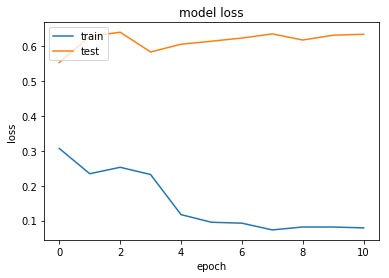

In [359]:
import matplotlib.pyplot as plt
history = final_model.history.__dict__['history']
plt.plot(history['categorical_accuracy'])
plt.plot(history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()